### Finite Difference method for solving discrete Laplace Equation

In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import linalg
from scipy.sparse import csc_matrix
from scipy.sparse import dia_array
from scipy.sparse import dia_matrix
import scipy.sparse.linalg as splinalg
from numba import njit, prange

In [2]:
N = 128
min, max = -5, 5
dx = (max - min) / N

In [3]:
def generate_D(n):
    ex = np.ones(n)
    data = np.array([-1 * ex, 4 * ex, -1 * ex])
    offsets = np.array([-1, 0, 1])
    
    return dia_matrix((data, offsets), shape=(n, n)).toarray()

In [4]:
@njit(parallel = True)
def kernel(N, A, D, I):
    for i in prange(N):
        for j in prange(N):
            if i == j:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = D[ii, jj]
                        
            if np.abs(i - j) == 1:
                for ii in prange(N):
                    for jj in prange(N):
                        A[ii+N*i, jj+N*j] = I[ii, jj]
                        
    return A

In [5]:
def generate_A(N):
    A = np.zeros((N ** 2, N ** 2))
    D = generate_D(N)
    I = -np.identity(N)
    A = kernel(N, A, D, I)
    return A

In [6]:
def rho(x, y):
    r1 = np.square(x + 1.5) + np.square(y)
    r2 = np.square(x - 1.5) + np.square(y)
    val = np.exp(-5 * 0.25 * np.square(r1)) + 3 * 0.5 * np.exp(-np.square(r2))
    return val

In [7]:
def kernel_source(RHO, N, x, y):
    for i in range(N):
        for j in range(N):
            RHO[i, j] = rho(x[i], y[j])

    return RHO

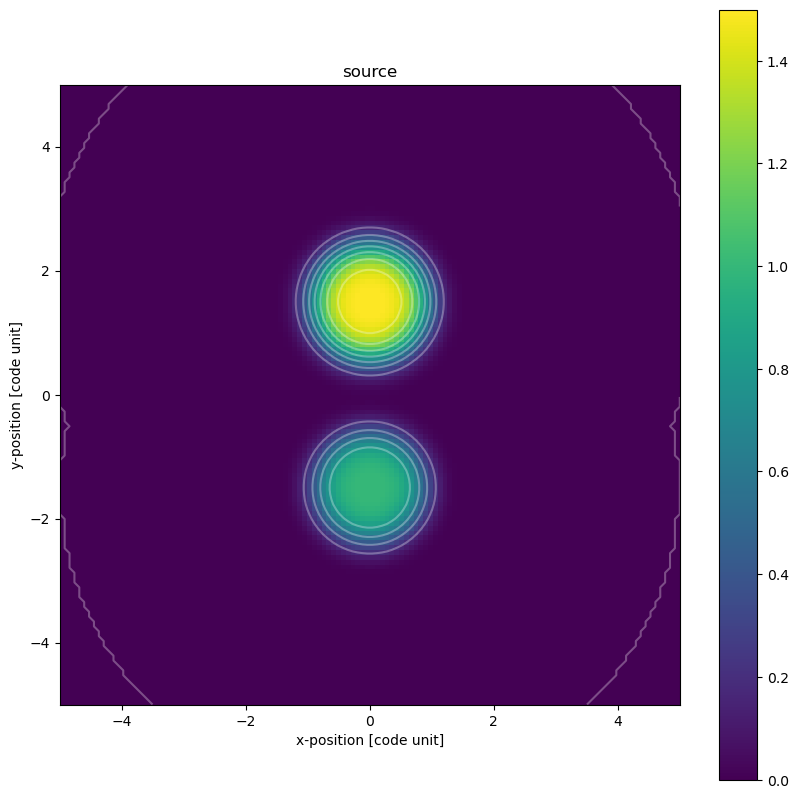

In [8]:
x = np.linspace(-5, 5, N)
y = np.linspace(-5, 5, N)
RHO = np.zeros([N, N])
ans = kernel_source(RHO, N, x, y)

figure(figsize=(10, 10), dpi=100)
plt.imshow(ans, origin = 'lower', extent=[-5, 5, -5, 5])
plt.colorbar()
plt.contour(ans, colors = 'w', alpha = .3, extent=[-5, 5, -5, 5])
plt.title('source')
plt.xlabel('x-position [code unit]')
plt.ylabel('y-position [code unit]')
plt.show()
plt.close()

In [9]:
def generate_g(N, rho, min, max):
    g = np.array([])
    n = np.linspace(min, max, N)
    for i in n:
        for j in n:
            g = np.append(g, rho(i, j))
    return g

In [10]:
def generate_b(N, g, dx):
    # boundaries
    # b = np.zeros(N ** 2)
    b = g.reshape(N, N)
    b[-1,:] = b[1,: ]
    b[:,-1] = b[:,-1]
    b = b.reshape(N ** 2)
    # source
    b += - g * np.square(dx)
    return b

In [11]:
# solve
def solve(N, rho, dx):
    g = generate_g(N, rho, min, max)
    a = generate_A(N)
    a = csc_matrix(a) # transform to the fitting matrix
    b = generate_b(N, g, dx)
    x = splinalg.spsolve(a, b).reshape(N, N)
    return x

In [12]:
u = solve(N, rho, dx)

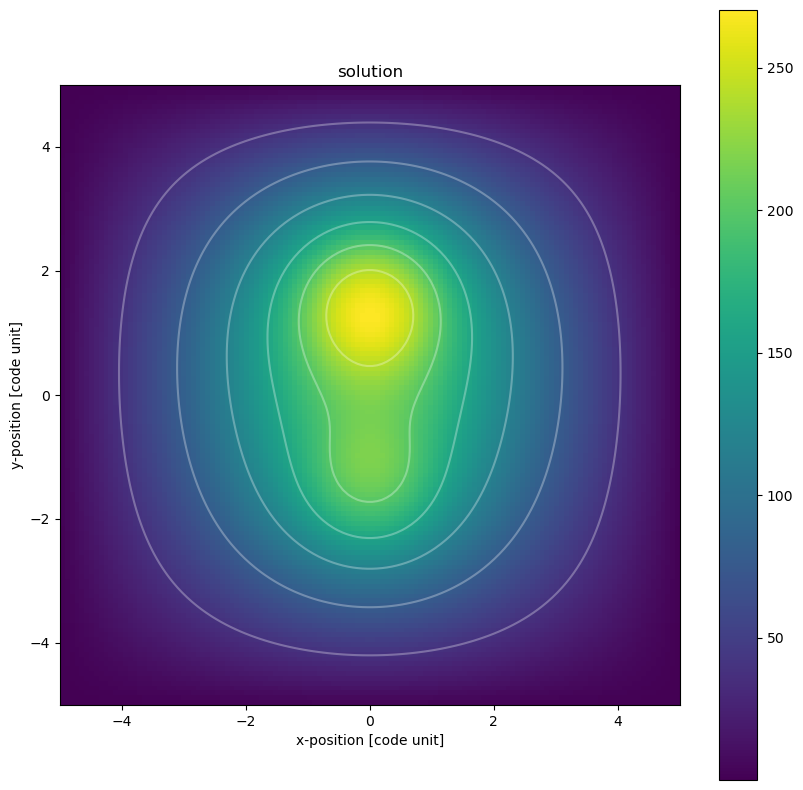

In [13]:
figure(figsize=(10, 10), dpi=100)
plt.imshow(u, origin = 'lower', extent=[-5, 5, -5, 5])
plt.colorbar()
plt.contour(u, colors = 'w', alpha = .3, extent=[-5, 5, -5, 5])
plt.title('solution')
plt.xlabel('x-position [code unit]')
plt.ylabel('y-position [code unit]')
plt.show()
plt.close()